In [10]:
import matplotlib.pyplot as plt
import netCDF4
import os, glob
import numpy as np
from scipy.interpolate import griddata
import h5py

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [11]:
CMROOT = r"C:\Users\axt5780\OneDrive - The Pennsylvania State University\PIML_project\IMERG_vectors"
nc_files = glob.glob(os.path.join(CMROOT, "*.nc"))

all_data = []
for nc_file in nc_files:
    channel_vec = netCDF4.Dataset(nc_file)
    data = channel_vec['pmmhr'][:, :]
    
    if np.isnan(data).any():
        valid_mask = ~np.isnan(data)
        nan_mask = np.isnan(data)  
        
        x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
      
        interpolated_data = griddata(
              points=(x[valid_mask], y[valid_mask]),
              values=data[valid_mask],
              xi=(x[nan_mask], y[nan_mask]),
              method='linear'
        )
        
        data[nan_mask] = interpolated_data
        
    all_data.append(data)
    channel_vec.close()
    
train = np.concatenate(all_data, axis=0)

print("Combined data shape:", train.shape)

Combined data shape: (17520, 39125)


In [12]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [13]:
shape = train.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(train, train,
              epochs=100,
          shuffle=True)

Epoch 1/100
548/548 [==============================] - 5s 9ms/step - loss: 0.3755
Epoch 2/100
548/548 [==============================] - 4s 8ms/step - loss: 0.3424
Epoch 3/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3359
Epoch 4/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3331
Epoch 5/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3315
Epoch 6/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3304
Epoch 7/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3296
Epoch 8/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3289
Epoch 9/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3284
Epoch 10/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3279
Epoch 11/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3276
Epoch 12/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3273
Epoch 13/100


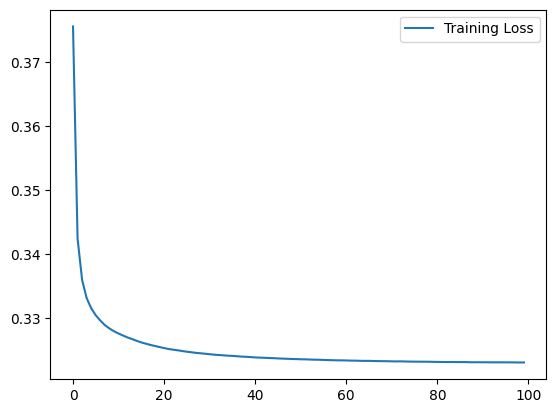

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [19]:
autoencoder.save_weights(f'weights/IMERG_{latent_dim}_downsample.h5')
print("Weights saved successfully.")

Weights saved successfully.
